In [2]:
import os
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, \
                            homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy as sc
import stlearn as st
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc

BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/DLPFC')
sample_list = ['151507', '151508', '151509', '151510', 
                '151669', '151670', '151671', '151672', 
                '151673', '151674', '151675', '151676']

def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'X_pca_kmeans'
    adata.obs['ground_truth'] = df_meta['ground_truth_le'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

# def calculate_clustering_matrix(pred, gt, sample, methods_):
#     df = pd.DataFrame(columns=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"])

#     pca_ari = adjusted_rand_score(pred, gt)
#     df = df.append(pd.Series([sample, pca_ari, "pca", methods_, "Adjusted_Rand_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)

#     pca_nmi = normalized_mutual_info_score(pred, gt)
#     df = df.append(pd.Series([sample, pca_nmi, "pca", methods_, "Normalized_Mutual_Info_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)

#     pca_purity = purity_score(pred, gt)
#     df = df.append(pd.Series([sample, pca_purity, "pca", methods_, "Purity_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)

#     pca_homogeneity, pca_completeness, pca_v_measure = homogeneity_completeness_v_measure(pred, gt)

#     df = df.append(pd.Series([sample, pca_homogeneity, "pca", methods_, "Homogeneity_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)


#     df = df.append(pd.Series([sample, pca_completeness, "pca", methods_, "Completeness_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)

#     df = df.append(pd.Series([sample, pca_v_measure, "pca", methods_, "V_Measure_Score"],
#                              index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
#     return df


# def purity_score(y_true, y_pred):
#     # compute contingency matrix (also called confusion matrix)
#     cm = contingency_matrix(y_true, y_pred)
#     # return purity
#     return np.sum(np.amax(cm, axis=0)) / np.sum(cm)
sample = '151507'
print(f"================ Start Processing {sample} ======================")

OUTPUT_PATH = Path(f"/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/DLPFC/stLearn/{sample}")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
TILE_PATH = Path(f'{OUTPUT_PATH}/tiles/')
TILE_PATH.mkdir(parents=True, exist_ok=True)

# Start time and memory usage tracking
start_time = time.time()
tracemalloc.start()

# Load data
data = st.Read10X(os.path.join(BASE_PATH, sample))
ground_truth_df = pd.read_csv( BASE_PATH / sample / 'metadata.tsv', sep='\t')
ground_truth_df['ground_truth'] = ground_truth_df['layer_guess']

# Pre-processing for ground truth
le = LabelEncoder()
ground_truth_le = le.fit_transform(list(ground_truth_df["ground_truth"].values))
n_cluster = len((set(ground_truth_df["ground_truth"]))) - 1
data.obs['ground_truth'] = ground_truth_df["ground_truth"]
ground_truth_df["ground_truth_le"] = ground_truth_le 

# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.em.run_pca(data,n_comps=15)
st.pp.tiling(data, TILE_PATH)
st.pp.extract_feature(data)

# stSME
st.spatial.SME.SME_normalize(data, use_data="raw", weights="physical_distance")
data_ = data.copy()
data_.X = data_.obsm['raw_SME_normalized']
st.pp.scale(data_)
st.em.run_pca(data_,n_comps=30)


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


================ Start Processing 151507 ======================


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
2025-02-14 13:33:16.881947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 13:33:17.035520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:
2025-02-14 13:33:17.035573: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-14 13:33:20.397735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not lo

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [35]:
import os
os.system(f'rm -rf {OUTPUT_PATH}/tiles')

0

In [6]:
st.tl.clustering.kmeans(data_, n_clusters=n_cluster, use_data="X_pca", key_added="X_pca_kmeans")

# End time and memory usage tracking
end_time = time.time()
time_taken = end_time - start_time
memory_used = tracemalloc.get_traced_memory()[1] / (1024 ** 2) # in MB
tracemalloc.stop()

print(data_)
# break
# Evaluate clustering
metrics = evaluate_clustering(data_, ground_truth_df, time_taken, memory_used, OUTPUT_PATH)

Applying Kmeans cluster ...


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]
AnnData object with n_obs × n_vars = 4226 × 21151
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'ground_truth', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'


Text(0.5, 1.0, 'stLearn (ARI = 0.4968)')

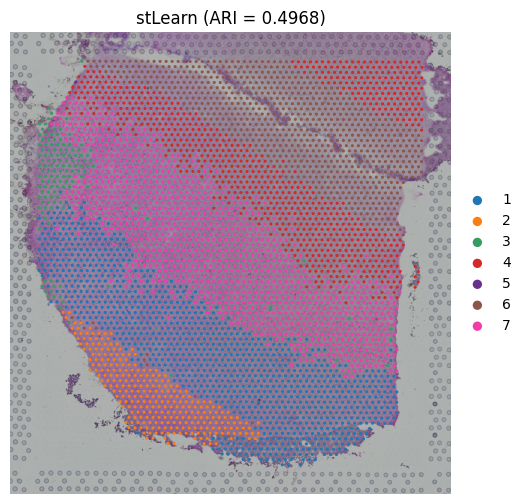

In [ ]:
# Plot clusters
fig, ax = plt.subplots(figsize=(6, 6))
st.pl.cluster_plot(data_, use_label="X_pca_kmeans", ax=ax)
handles, labels = ax.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
ax.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5), markerscale=3)
plt.title(f"stLearn (ARI = {metrics['ARI']:.4f})")
# plt.savefig(OUTPUT_PATH / 'cluster.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [5]:
# methods_ = "stSME_disk"
# results_df = calculate_clustering_matrix(data_.obs["X_pca_kmeans"], ground_truth_le, sample, methods_)
data_.obs.to_csv(OUTPUT_PATH / 'cell_metadata.csv', index=False)
df_PCA = pd.DataFrame(data = data_.obsm['X_pca'], index = data_.obs.index)
df_PCA.to_csv(OUTPUT_PATH / 'low_dim_data.csv', index=False)

# umap_coords = data_.obsm["X_umap"]
print("================ End ======================")

TypeError: to_csv() got an unexpected keyword argument 'indx'

In [20]:
data_

AnnData object with n_obs × n_vars = 4226 × 21151
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'ground_truth', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'

In [38]:
data_

AnnData object with n_obs × n_vars = 4226 × 21151
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'ground_truth', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
data_.obsm['X_pca_kmeans'] = data_.obs['X_pca_kmeans']

In [52]:
st.pp.neighbors(data_, n_neighbors=30, use_rep="X_pca")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [53]:
st.em.run_umap(data_)

UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


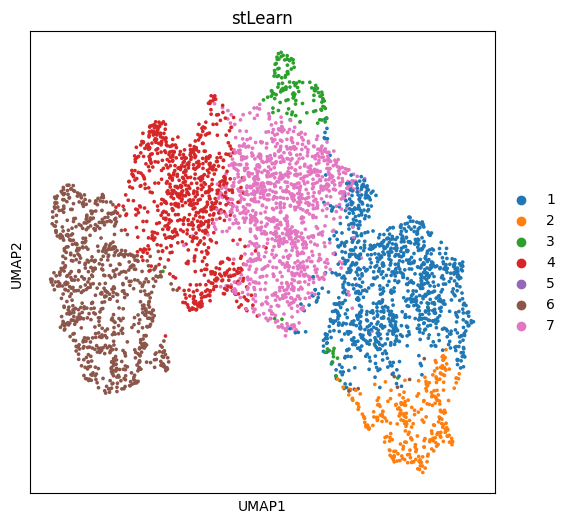

In [61]:
data_.obs['X_pca_kmeans_shift'] = (data_.obs['X_pca_kmeans'].astype(int) + 1).astype(str)

fig, ax_new = plt.subplots(figsize=(6, 6))
sc.pl.umap(data_, color='X_pca_kmeans_shift', title='stLearn', ax=ax_new)

# handles, labels = ax_new.get_legend_handles_labels()
# new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
# ax_new.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5), markerscale=3)
# plt.title(f"stLearn")
# plt.show()

In [41]:
data_

AnnData object with n_obs × n_vars = 4226 × 21151
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'ground_truth', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'X_pca_kmeans_colors', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized', 'X_umap', 'X_pca_kmeans'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
data_.obsm['X_umap']

array([[ 1.6846168, 13.628288 ],
       [ 6.1115823,  8.116383 ],
       [-3.1455822,  4.7892933],
       ...,
       [15.554    ,  6.1925282],
       [12.355408 ,  8.756625 ],
       [-3.0686028,  1.5455611]], dtype=float32)

In [34]:
umap_coords = data_.obsm["X_umap"]
spot_ids = data_.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]


,spot_id,UMAP1,UMAP2
0,AAACAACGAATAGTTC-1,1.684617,13.628288
1,AAACAAGTATCTCCCA-1,6.111582,8.116383
2,AAACAATCTACTAGCA-1,-3.145582,4.789293
3,AAACACCAATAACTGC-1,15.952679,5.117535
4,AAACAGCTTTCAGAAG-1,13.009024,8.833803
...,...,...,...
4221,TTGTTGTGTGTCAAGA-1,3.302585,9.921444
4222,TTGTTTCACATCCAGG-1,12.223739,5.978616
4223,TTGTTTCATTAGTCTA-1,15.554000,6.192528
4224,TTGTTTCCATACAACT-1,12.355408,8.756625
